In this version we'll experiment with a different optimiser. Currently we're using SGD with a learning rate of 0.01, but there's a few potential problems with this. Firstly, the SGD learning rate requires tuning by trial and error, which is a time inefficient optimisation method. Secondly, SGD converges relatively slowly, especially with data augmentation and small batch sizes. We want to limit the runtime to just a few minutes while optimising performance, so we definitely want an optimiser that converges faster. A good choice for this is the Adam optimiser. The Adam (Adaptive Moment Estimation) optimiser uses RMSprop (root mean square propagation), which is a learning rate optimisation algorithm. RMSprop iteratively updates learning rate based on an exponentially weighted moving average of squared gradients. This should improve convergence rates, therefore improving the observed accuracy for a limited runtime.

In [1]:
import torch #creates/trains models and performs tensor operations
import torchvision #gives popular datasets, model architectures and image processing stuff
import torchvision.transforms as transforms #helps preprocess images to help model use them
import matplotlib.pyplot as plt
import numpy as np

**Data Augmentation**

In [2]:
batch_size = 10
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),   #flips image with 50% probability
    transforms.RandomRotation(10),       #rotates image either +10 or -10 degrees
    transforms.RandomCrop(32, padding=1),#now only pads 1 pixel
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1), # random color changes
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalising as before
])
transform_test = transforms.Compose([  #we keep the old transformations on the test set
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

**Downloading and loading augmented Dataset**

In [3]:
print("Downloading training data...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train) #we apply the new augmented transformation to the training set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

print("Downloading testing data...")
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test) #and apply a non-augmenting transform to the test set
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [4]:
print(testset.transform)

Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)


In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
traindataiter = iter(trainloader)
images, labels = next(traindataiter)

**Visualising images**

We check that the images have been altered correctly:

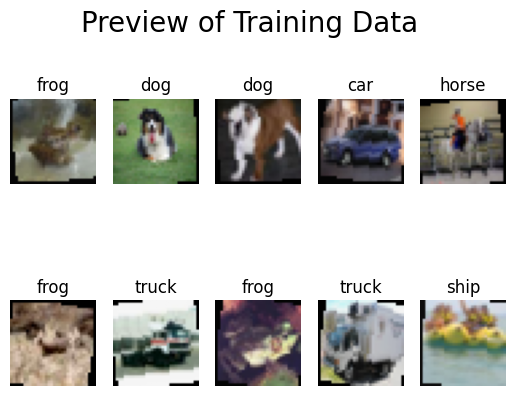

In [6]:
for i in range(batch_size):
    plt.subplot(2, int(batch_size/2), i + 1) #creates subplots
    img = images[i] #extracts each image
    img = img / 2 + 0.5 #undoes normalisation to restore original colour range
    npimg = img.numpy() #convert tensor to numpy array so we can plot with matplotlib
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #adjusts image dimensions
    plt.axis('off')
    plt.title(classes[labels[i]]) #labels subplots

plt.suptitle('Preview of Training Data', size=20)
plt.show()

In [7]:
testdataiter = iter(testloader)
images, labels = next(testdataiter)

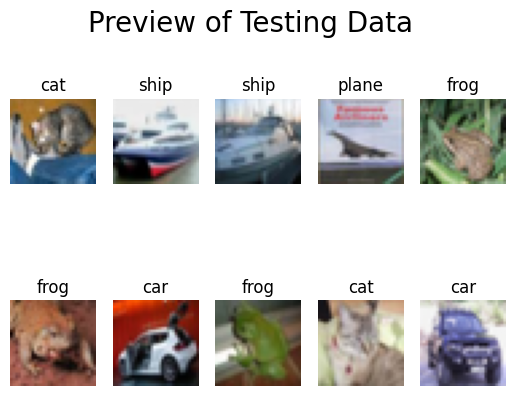

In [8]:
for i in range(batch_size):
    plt.subplot(2, int(batch_size/2), i + 1) #creates subplots
    img = images[i] #extracts each image
    img = img / 2 + 0.5 #undoes normalisation to restore original colour range
    npimg = img.numpy() #convert tensor to numpy array so we can plot with matplotlib
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #adjusts image dimensions
    plt.axis('off')
    plt.title(classes[labels[i]]) #labels subplots

plt.suptitle('Preview of Testing Data', size=20)
plt.show()

**Architecture**

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # First defining layers
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)

        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.bn3 = nn.BatchNorm1d(120)

        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)

        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        # Conv block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)

        # Conv block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)

        # Flattening
        x = torch.flatten(x, 1)

        # Fully connected block 1
        x = self.fc1(x)
        x = self.bn3(x)
        x = F.relu(x)

        # Fully connected block 2
        x = self.fc2(x)
        x = self.bn4(x)
        x = F.relu(x)

        # Output layer
        x = self.fc3(x)

        return x

**Training the Neural Network**

**Changing the optimiser**

Now we replace the SGD optimiser with Adam. Note that we remove the momentum argument since momentum is baked into the Adam framework.

In [10]:
net = Net()

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)  # Using Adam instead of SGD


print("Your network is ready for training!")

Your network is ready for training!


**Training and saving the model**

In [11]:
from tqdm import tqdm

train_losses = []
test_accuracies = []

EPOCHS = 20
for epoch in range(EPOCHS):
    net.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{EPOCHS}", ncols=80):
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)  # Sum loss for all samples in batch

    # Average training loss for the epoch
    epoch_loss = running_loss / len(trainset)
    train_losses.append(epoch_loss)

    # Evaluate on test set
    net.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{EPOCHS} - Training Loss: {epoch_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

#saving our trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Epoch 1/20: 100%|███████████████████████████| 5000/5000 [01:17<00:00, 64.20it/s]


Epoch 1/20 - Training Loss: 1.5819, Test Accuracy: 54.26%


Epoch 2/20: 100%|███████████████████████████| 5000/5000 [01:18<00:00, 63.86it/s]


Epoch 2/20 - Training Loss: 1.3808, Test Accuracy: 59.09%


Epoch 3/20: 100%|███████████████████████████| 5000/5000 [01:17<00:00, 64.22it/s]


Epoch 3/20 - Training Loss: 1.3112, Test Accuracy: 61.03%


Epoch 4/20: 100%|███████████████████████████| 5000/5000 [01:17<00:00, 64.18it/s]


Epoch 4/20 - Training Loss: 1.2646, Test Accuracy: 62.30%


Epoch 5/20: 100%|███████████████████████████| 5000/5000 [01:19<00:00, 62.84it/s]


Epoch 5/20 - Training Loss: 1.2198, Test Accuracy: 63.90%


Epoch 6/20: 100%|███████████████████████████| 5000/5000 [01:18<00:00, 63.68it/s]


Epoch 6/20 - Training Loss: 1.2024, Test Accuracy: 64.76%


Epoch 7/20: 100%|███████████████████████████| 5000/5000 [01:17<00:00, 64.27it/s]


Epoch 7/20 - Training Loss: 1.1798, Test Accuracy: 65.21%


Epoch 8/20: 100%|███████████████████████████| 5000/5000 [01:17<00:00, 64.51it/s]


Epoch 8/20 - Training Loss: 1.1683, Test Accuracy: 65.28%


Epoch 9/20: 100%|███████████████████████████| 5000/5000 [01:16<00:00, 65.04it/s]


Epoch 9/20 - Training Loss: 1.1483, Test Accuracy: 67.20%


Epoch 10/20: 100%|██████████████████████████| 5000/5000 [01:18<00:00, 64.09it/s]


Epoch 10/20 - Training Loss: 1.1396, Test Accuracy: 66.71%


Epoch 11/20: 100%|██████████████████████████| 5000/5000 [01:17<00:00, 64.41it/s]


Epoch 11/20 - Training Loss: 1.1286, Test Accuracy: 67.46%


Epoch 12/20: 100%|██████████████████████████| 5000/5000 [01:17<00:00, 64.26it/s]


Epoch 12/20 - Training Loss: 1.1093, Test Accuracy: 67.32%


Epoch 13/20: 100%|██████████████████████████| 5000/5000 [01:18<00:00, 64.06it/s]


Epoch 13/20 - Training Loss: 1.0978, Test Accuracy: 67.30%


Epoch 14/20: 100%|██████████████████████████| 5000/5000 [01:17<00:00, 64.13it/s]


Epoch 14/20 - Training Loss: 1.0977, Test Accuracy: 69.01%


Epoch 15/20: 100%|██████████████████████████| 5000/5000 [01:18<00:00, 63.47it/s]


Epoch 15/20 - Training Loss: 1.0803, Test Accuracy: 68.62%


Epoch 16/20: 100%|██████████████████████████| 5000/5000 [01:18<00:00, 63.69it/s]


Epoch 16/20 - Training Loss: 1.0838, Test Accuracy: 68.05%


Epoch 17/20: 100%|██████████████████████████| 5000/5000 [01:19<00:00, 63.11it/s]


Epoch 17/20 - Training Loss: 1.0824, Test Accuracy: 68.41%


Epoch 18/20: 100%|██████████████████████████| 5000/5000 [01:18<00:00, 63.80it/s]


Epoch 18/20 - Training Loss: 1.0639, Test Accuracy: 68.97%


Epoch 19/20: 100%|██████████████████████████| 5000/5000 [01:17<00:00, 64.48it/s]


Epoch 19/20 - Training Loss: 1.0667, Test Accuracy: 68.92%


Epoch 20/20: 100%|██████████████████████████| 5000/5000 [01:19<00:00, 63.23it/s]


Epoch 20/20 - Training Loss: 1.0562, Test Accuracy: 69.97%


Now we plot our training loss and test accuracy

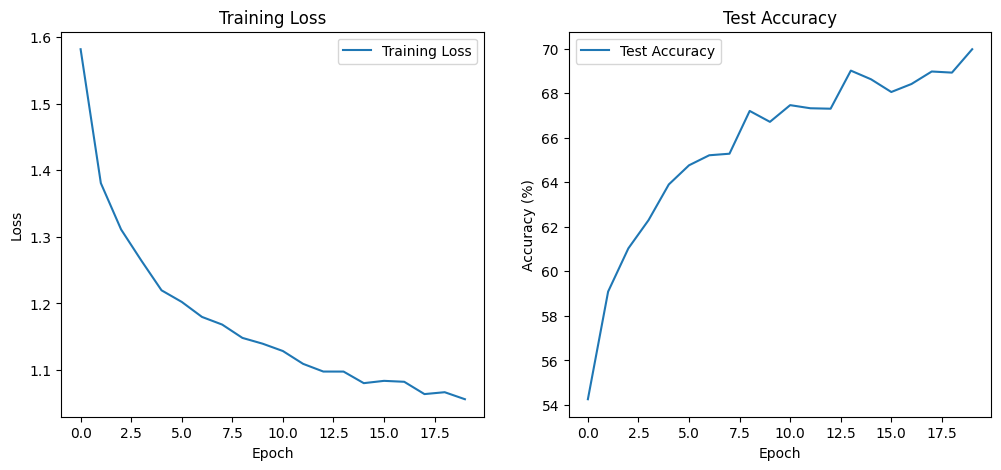

In [12]:
# Training Loss plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Test Accuracy plot
plt.subplot(1,2,2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()

plt.show()

These graphs are promising, and indicate that learning steadily increased throughout the 20 epochs. It looks like the model reaches about 70% by the final epoch which is quite promising.

**Testing the model**

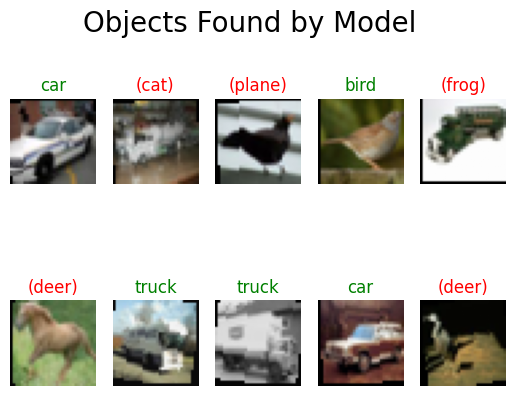

In [13]:
# Pick random photos from training set
if traindataiter == None:
    traindataiter = iter(trainloader)
images, labels = next(traindataiter)

# Load our model
net = Net()
net.load_state_dict(torch.load(PATH))

# Analyze images
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Show results
for i in range(batch_size):
    # Add new subplot
    plt.subplot(2, int(batch_size/2), i + 1)
    # Plot the image
    img = images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Add the image's label
    color = "green"
    label = classes[predicted[i]]
    if classes[labels[i]] != classes[predicted[i]]:
        color = "red"
        label = "(" + label + ")"
    plt.title(label, color=color)

plt.suptitle('Objects Found by Model', size=20)
plt.show()

**Evaluating model accuracy**

In [14]:
# Measure accuracy for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy statistics
accuracies = []
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    accuracies.append(accuracy)
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

average_accuracy = sum(accuracies) / len(accuracies)
print(f'\nAverage accuracy over all classes: {average_accuracy:.1f} %') #we  add some code to measure overall accuracy as our baseline performance metric

Accuracy for class: plane is 64.8 %
Accuracy for class: car   is 78.5 %
Accuracy for class: bird  is 48.1 %
Accuracy for class: cat   is 43.5 %
Accuracy for class: deer  is 60.8 %
Accuracy for class: dog   is 50.2 %
Accuracy for class: frog  is 72.5 %
Accuracy for class: horse is 70.4 %
Accuracy for class: ship  is 78.2 %
Accuracy for class: truck is 75.1 %

Average accuracy over all classes: 64.2 %


So our final accuracy score is 64%, which is a good increase from the initial 50%.